In [1]:
import numpy as np
import pickle
from pathlib import Path
import time
import torch
from livelossplot import PlotLosses
import matplotlib.pyplot as plt
%matplotlib inline 
from torchsummary import summary
from torcheval import metrics
import torch.nn as nn


In [2]:
if torch.cuda.is_available(): 
 dev = "cuda" 
else: 
 dev = "cpu" 
device = torch.device(dev) 


In [694]:
data_path =  'data/Ferguson_fire_train.npy'
train_data = np.load(data_path)
test_path =  'data/Ferguson_fire_test.npy'
test_data = np.load(test_path)

In [695]:
# split_size = 5
# train_4d=train_data.reshape(125,100,256,256)[:,::split_size,:,:][:,:-1,:,:]
# train_shift_4d=train_data.reshape(125,100,256,256)[:,::split_size,:,:][:,1:,:,:]
# test_4d = test_data.reshape(50,100,256,256)[:,::split_size,:,:][:,:-1,:,:]
# test_shift_4d= test_data.reshape(50,100,256,256)[:,::split_size,:,:][:,1:,:,:]

In [696]:
split_size = 5
train1_4d=train_data.reshape(125,100,256,256)[:,::split_size,:,:][:,:-1,:,:]
train2_4d=train_data.reshape(125,100,256,256)[:,::split_size,:,:][:,:-1,:,:]


train1_shift_4d=train_data.reshape(125,100,256,256)[:,::split_size,:,:][:,1:,:,:]
test1_4d = test_data.reshape(50,100,256,256)[:,::split_size,:,:][:,:-1,:,:]
test1_shift_4d= test_data.reshape(50,100,256,256)[:,::split_size,:,:][:,1:,:,:]

In [697]:
trainshiftloader.dataset.shape

torch.Size([125, 19, 256, 256])

In [698]:
assert (train_shift_4d[0][1].all() ==train_4d[0][2].all())
assert (test_shift_4d[0][1].all() == test_4d[0][2].all())

In [699]:
del train_data, test_data

In [700]:
trainloader = torch.utils.data.DataLoader(torch.tensor(train_4d,dtype=torch.float32),batch_size=16, shuffle = False)
trainshiftloader = torch.utils.data.DataLoader(torch.tensor(train_4d,dtype=torch.float32),batch_size=16, shuffle = False)
testloader = torch.utils.data.DataLoader(torch.tensor(test_4d,dtype=torch.float32),batch_size=16, shuffle = False)
testshiftloader = torch.utils.data.DataLoader(torch.tensor(test_4d,dtype=torch.float32),batch_size=16, shuffle = False)

In [701]:
assert(trainloader.dataset.shape==trainshiftloader.dataset.shape)


### Code for Training the Model in model_training.ipynb notebook

In [759]:

class VAE(nn.Module):
    def __init__(self, latent_dim = 64, channel_size = 9,latent_pixel_size = 16):
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(
            
            nn.Conv3d(1, 8, kernel_size=(5,6,6), stride=(1,2,2), padding=(2,2,2)),  # Example for 3D conv layer
            nn.LeakyReLU(),
            nn.Conv3d(8, 4, kernel_size=(3,4,4), stride=(1,2,2), padding=1),
            nn.LeakyReLU(),
            nn.Conv3d(4,1, kernel_size=(3,4,4), stride=(1,2,2), padding=1),
        
        
            nn.LeakyReLU(),
    

            nn.Flatten(),
            nn.Linear(latent_pixel_size*latent_pixel_size*channel_size,256),
            nn.LeakyReLU(),
            nn.Dropout(),
            
        )
        ### Latent space transformations

        self.mu = nn.Linear(256,latent_dim)
        self.logvar = nn.Linear(256,latent_dim)
        
        
        self.decoder = nn.Sequential(
            
            nn.Linear(latent_dim, 256),

            nn.LeakyReLU(),
            nn.Linear(256,latent_pixel_size*latent_pixel_size*channel_size),
            nn.Unflatten(1,(1,channel_size,latent_pixel_size,latent_pixel_size)),

            nn.ConvTranspose3d(1,4, kernel_size = (3,4,4), stride= (1,2,2), padding = 1),
            nn.LeakyReLU(),
            nn.ConvTranspose3d(4, 8, kernel_size=(3,4,4), stride=(1,2,2), padding=1),
            nn.LeakyReLU(),
            nn.ConvTranspose3d(8, 1, kernel_size=(5,6,6), stride=(1,2,2), padding=2),

            nn.Sigmoid()
        )

    def encode(self, x):
        x = self.encoder(x)
        mu = self.mu(x)
        logvar = self.logvar(x)
        
        return mu, logvar
        
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)  # Calculate standard deviation from log variance
        eps = torch.randn_like(std)
        return mu + eps * std
        
    def decode(self, x):
        return self.decoder(x)

    def forward(self, x):
        mu, logvar = self.encode(x)
        
        z = self.reparameterize(mu, logvar)
        z = self.decode(z)
        return z, mu, logvar

 


In [760]:
conv3d_layer = nn.Conv3d(
    in_channels=1,      # Number of input channels
    out_channels=8,     # Number of output channels
    kernel_size=(5,6,6),  # Kernel size
    stride=(1, 2, 2),   # Stride
    padding=(2, 2,2)   # Padding to maintain the size
)

# Example input tensor with shape (batch_size, channels, depth, height, width)
input_tensor = torch.randn(1, 1, 9, 256, 256)

# Applying the Conv3d layer
output_tensor = conv3d_layer(input_tensor)
output_tensor.shape

torch.Size([1, 8, 9, 128, 128])

In [761]:
#torch.Size([1, 8, 9, 128, 128])

#### Show layers in my model

In [762]:
torch.cuda.empty_cache()
channel_size = 100//split_size -1
model = VAE(latent_dim =16, channel_size = channel_size,latent_pixel_size=32
             ).to(device)
summary(model, (1,channel_size,256,256))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv3d-1      [-1, 8, 19, 128, 128]           1,448
         LeakyReLU-2      [-1, 8, 19, 128, 128]               0
            Conv3d-3        [-1, 4, 19, 64, 64]           1,540
         LeakyReLU-4        [-1, 4, 19, 64, 64]               0
            Conv3d-5        [-1, 1, 19, 32, 32]             193
         LeakyReLU-6        [-1, 1, 19, 32, 32]               0
           Flatten-7                [-1, 19456]               0
            Linear-8                  [-1, 256]       4,980,992
         LeakyReLU-9                  [-1, 256]               0
          Dropout-10                  [-1, 256]               0
           Linear-11                   [-1, 16]           4,112
           Linear-12                   [-1, 16]           4,112
           Linear-13                  [-1, 256]           4,352
        LeakyReLU-14                  [

In [763]:

# def train(model, optimizer, criterion, data_loader, scheduler = 0):
#     model.train()
#     train_loss = 0
#     for X in data_loader:
#         X = X.to(device).view(-1,1,5,256,256)
#         optimizer.zero_grad()
#         embedding_loss, a2, perplexity = model(X)



#         recon_loss = criterion(a2,X)
#         loss = embedding_loss + recon_loss
#         loss.backward()
#         train_loss += loss*X.size(0)
#         optimizer.step()
#         if scheduler !=0:
#             scheduler.step()

#     return train_loss/len(data_loader.dataset),  recon_loss/len(data_loader.dataset)

###with VQ
def train(model, optimizer, criterion, dataloader,testloader, t = 99, scheduler = 0):
    model.train()
    train_loss = 0
    for X, Y in zip(dataloader, testloader):
        X = X.to(device).view(-1,1,t,256,256)
        Y = Y.to(device).view(-1,1,t,256,256)
        optimizer.zero_grad()
        a2, mu, logvar =model(X)
        loss = criterion(Y, a2, mu, logvar)
        mus.append(mu)
        sigmas.append(logvar)
        loss.backward()
        train_loss += loss*X.size(0)
        optimizer.step()
        if scheduler !=0:
            scheduler.step()

    return train_loss/len(dataloader.dataset)
    
def validate(model, criterion, dataloader,testloader, t = 99):
    model.eval()
    valid_loss = 0
    with torch.no_grad():
        for X, Y in zip(dataloader, testloader):
            X = X.to(device).view(-1,1,t,256,256)
            Y = Y.to(device).view(-1,1,t,256,256)
            a2, mu, logvar =model(X)
            loss = criterion(Y, a2, mu, logvar)
            valid_loss += loss*X.size(0)
    return valid_loss/len(dataloader.dataset)

In [764]:
def loss_function(x, x_hat, mu, logvar):
    # Flatten the input and output for binary cross-entropy loss calculation
    x = x.view(-1, x.size(1) * x.size(2) * x.size(3) * x.size(4))
    x_hat = x_hat.view(-1, x_hat.size(1) * x_hat.size(2) * x_hat.size(3) * x_hat.size(4))
    
    # MSE loss
    reproduction_loss = mseloss(x_hat, x)#, reduction='mean')
    
    # KL divergence loss
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    
    return reproduction_loss + KLD

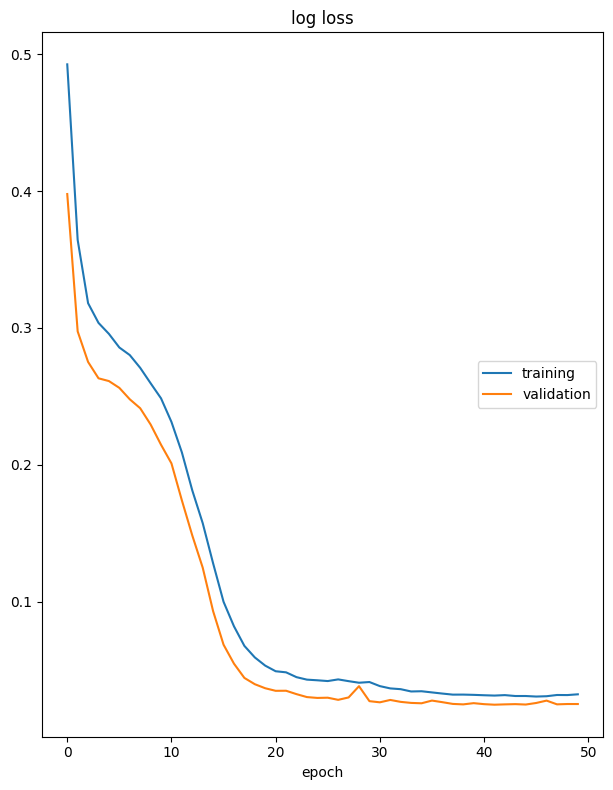

log loss
	training         	 (min:    0.031, max:    0.493, cur:    0.032)
	validation       	 (min:    0.025, max:    0.398, cur:    0.025)


In [765]:
epochs = 50

mus= []
sigmas = []
# save_path = "VAE.pth"
# try: 
#     model.load_state_dict(torch.load("VAE.pth",map_location='cpu'))
# except FileNotFoundError:

loss_function = loss_function #torch.nn.MSELoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
 
mseloss = nn.MSELoss()

liveloss = PlotLosses()
for epoch in range(epochs):
    logs = {}
    loss1 = train(model, optimizer, loss_function, trainloader, trainshiftloader, channel_size)
    
    loss2 = validate(model, loss_function, testloader,testshiftloader,channel_size)
    logs['' + 'log loss'] = loss1.item()
    logs['val_' + 'log loss'] = loss2.item()
    liveloss.update(logs)
    liveloss.draw()
    
    
        


In [766]:
nums = (torch.randn((2,16))).to(device)
samples = model.decode(nums).cpu().detach().numpy()


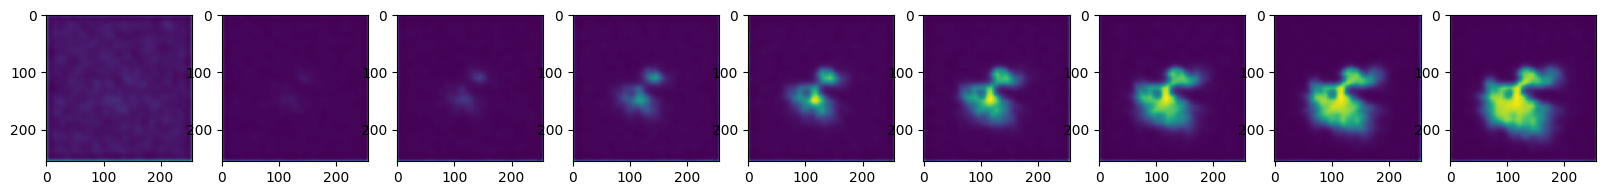

In [767]:
fig ,ax = plt.subplots(1,9, figsize = (20,10))
for i in range(9):
        ax[i].imshow(samples[1].reshape(1,channel_size,256,256)[0][i*2])

plt.show()

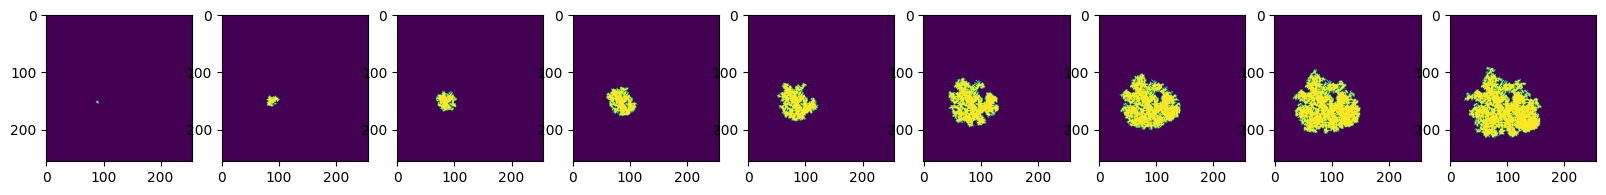

In [784]:
fig ,ax = plt.subplots(1,9, figsize = (20,10))
for i in range(9):
        ax[i].imshow(train_4d[100][i*2])

plt.show()

In [785]:
torch.save(model, "model.pth")